In [28]:
library(CellChat)
library(RColorBrewer)
library(Seurat)
library(nichenetr)
library(tidyverse)
library(dplyr)

## The number of interactions
* CellChat

In [ ]:
PRE_CR_CELLCHAT_OBJECT_PATH = 'project_path/cellchat/sizeFactor_preCR_allCell.rds'
PRE_NCR_CELLCHAT_OBJECT_PATH = 'project_path/cellchat/sizeFactor_preNCR_allCell.rds'
ALLSUBS_CELLCHAT_OBJECT_PATH = 'project_path/cellchat/allCell.rds'

### Figure 4G

In [19]:
pre_NC = readRDS(PRE_CR_CELLCHAT_OBJECT_PATH)
pre_NCR = readRDS(PRE_NCR_CELLCHAT_OBJECT_PATH)

object.list = list(pre_CR = pre_NC, pre_NCR = pre_NCR)
cellchat = mergeCellChat(object.list, add.names = names(object.list))

Merge the following slots: 'data.signaling','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



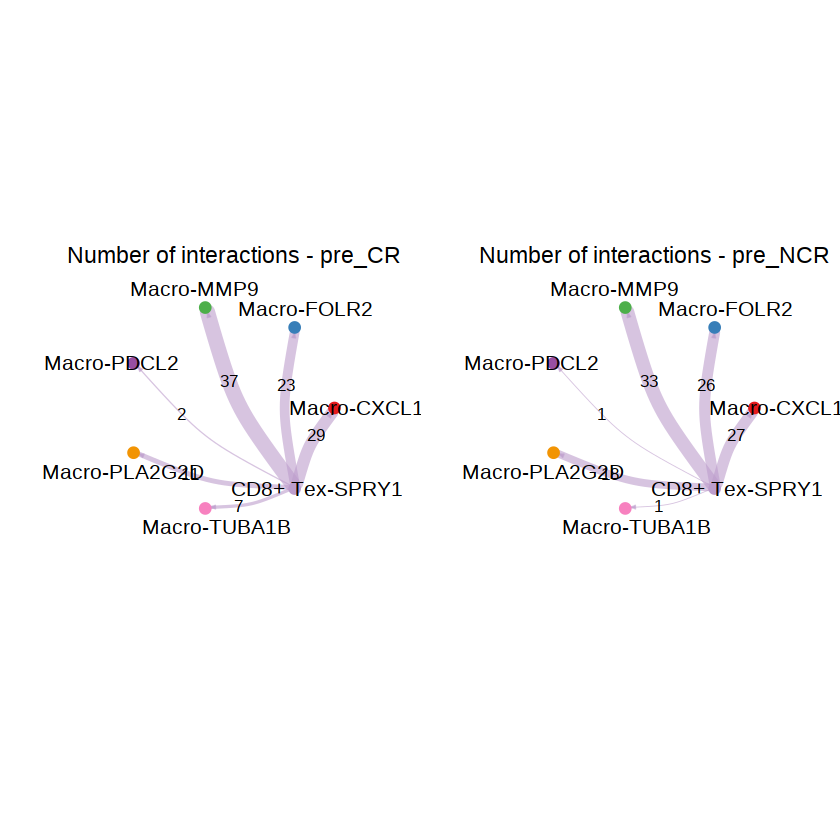

In [22]:
cells = c('Macro-CXCL1','Macro-FOLR2','Macro-MMP9','Macro-PDCL2','Macro-PLA2G2D','Macro-TUBA1B','CD8+ Tex-SPRY1')
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
    count = object.list[[i]]@net$count
    aa = rownames(count)
    aa[which(aa == 'Macro-DEFA3')] = 'Macro-CXCL1'
    rownames(count) = aa
    colnames(count) = aa
    netVisual_circle(count[cells,cells], weight.scale = T, label.edge= T, edge.weight.max = 50, 
                   sources.us = 'CD8+ Tex-SPRY1',
                   targets.use = c('Macro-CXCL1','Macro-FOLR2','Macro-MMP9','Macro-PDCL2','Macro-PLA2G2D','Macro-TUBA1B'),
                   edge.width.max = 12, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

### Figure 5C

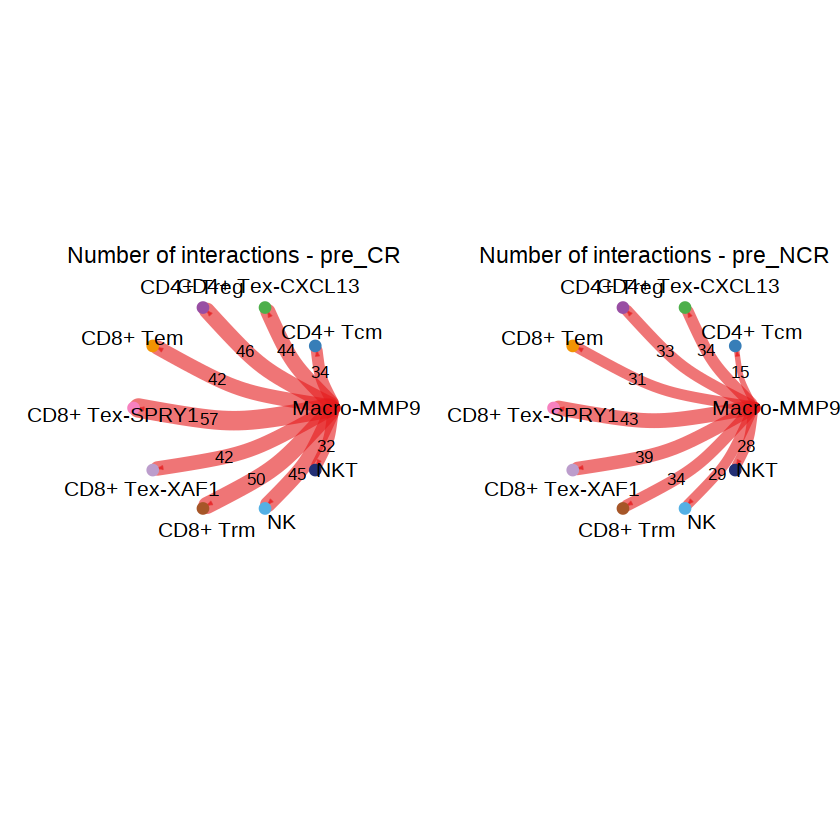

In [23]:
cells = c('Macro-MMP9','CD4+ Tcm','CD4+ Tex-CXCL13','CD4+ Treg','CD8+ Tem','CD8+ Tex-SPRY1','CD8+ Tex-XAF1','CD8+ Trm','NK','NKT')
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
    netVisual_circle(object.list[[i]]@net$count[cells,cells], weight.scale = T, label.edge= T, edge.weight.max = 60, 
                   sources.us = 'Macro-MMP9',
                   targets.use = cells[2:length(cells)],
                   edge.width.max = 12, title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

### Figure 6I

In [25]:
cellchat = readRDS(ALLSUBS_CELLCHAT_OBJECT_PATH)

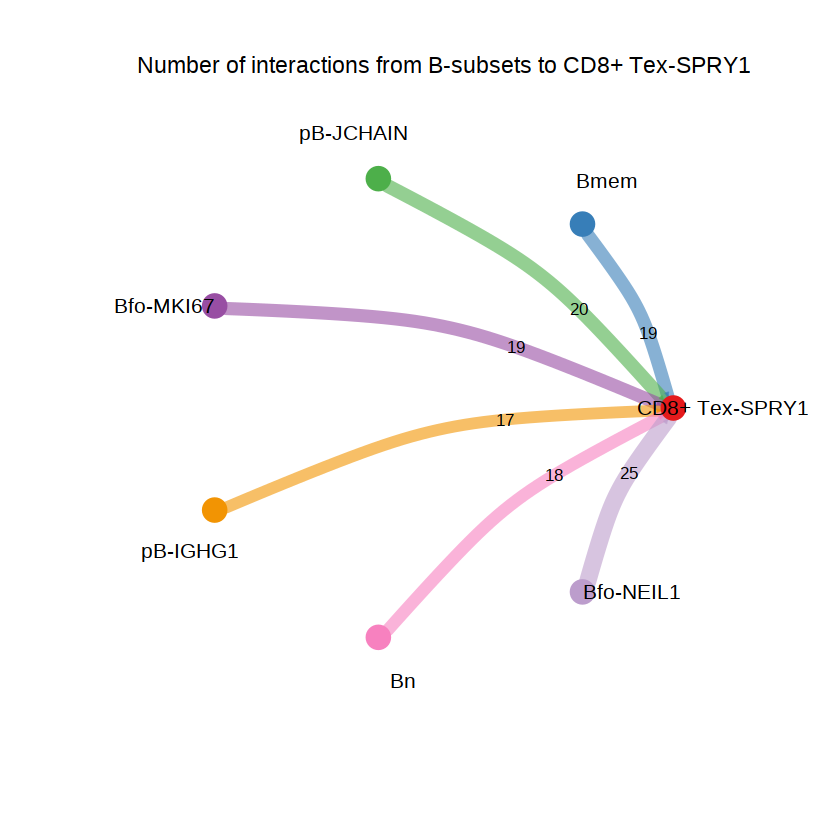

In [27]:
cells = c('CD8+ Tex-SPRY1','Bmem','pB-JCHAIN','Bfo-MKI67','pB-IGHG1','Bn','Bfo-NEIL1')
p = netVisual_circle(cellchat@net$count[cells,cells], weight.scale = T, label.edge= T,  edge.weight.max = 30, 
                   sources.us = cells[2:7],
                   targets.use = 'CD8+ Tex-SPRY1',
                   edge.width.max = 12, title.name = paste0("Number of interactions from B-subsets to CD8+ Tex-SPRY1"))